# MONTE CARLO EXPERIMENTS

---

NOTE TO THE READER: We often encounter across this error:

     19     # Reset the environment getting the initial state

---> 20     state,info = env.reset()

     21     bucket_state = bucketize(state)
     
     22
ValueError: too many values to unpack (expected 2)

or "the truth value cannot be determined for a.all()"

This is a know issue that unfortunatley we have not been able to resolve.
To fix this, one must go to the line in the error that reads:
"state,info = env.reset()" or  "new_state, reward, done, trunc,info = env.step(action)" and remove the 'info'. Or add it back in if it is missing. We apologize for this inconvenience.




---



## Importing packages

In [11]:
import numpy as np
import gym
import random
import math

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import copy
import pandas as pd
import seaborn as sns

from numpy.typing import NDArray
import itertools
import json
import time

from typing import List, Optional, Tuple, Union, Callable, Dict, Sequence

import matplotlib.pyplot as plt
import numpy as np
from os import pipe
%matplotlib inline

In [2]:
sns.set_context("talk")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
colab_requirements = [
    "gymnasium",
    "numpy",
    "pandas",
    "seaborn"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)
        run_subprocess_command("apt install swig xvfb x11-utils")
        run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.3 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 swig4.0 x11-xkb-utils xfonts-base
xfonts-encodings xfonts-utils xserver-common
Suggested packages:
swig-doc swig-examples swig4.0-examples swig4.0-doc mesa-utils
The following NEW packages will be installed:
libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 swig swig4.0 x11-utils x11-xkb-utils
xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,161 kB of archives.
After this operation, 18.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get

In [4]:
# To display GIF images in the notebook
def is_colab():
    return "google.colab" in sys.modules


import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

In [15]:
def choose_action(qTable,state,epsilon=0.05):
  if np.random.random() < epsilon:
    return np.random.choice([0,1,2,3])
  else:
    return np.argmax(qTable[state])

In [22]:
# Variables

# Discount Factor
gamma = 0.99



---



# This notebook is based on the notebook from: from: Omar Gutierrez: https://github.com/omargup/Lunar-Lander

> [1]
“omargup/Lunar-Lander: Tabular Monte Carlo, Sarsa, Q-Learning and Expected Sarsa to solve OpenAI GYM Lunar Lander,” GitHub, 2024. https://github.com/omargup/Lunar-Lander (accessed Mar. 28, 2024).
‌



# Specifically the cells in the following section have been copied nearly exactly:

In [16]:
def create_env():
    return gym.make('LunarLander-v2')

## Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in $[a,b]$ and if the number of buckets for that dimension is $n$, we are going to interpolate that real value into an integer in $[0,n-1]$.

In [17]:
def set_buckets_and_actions(n):
    number_of_buckets = (n,n,n,n,n,n,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n

    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))

    #New bound values for each dimension
    state_value_bounds[0] = [-0.60,0.60]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]

    return number_of_buckets, number_of_actions, state_value_bounds

# Environment Creation
env = create_env()
#env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")

number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [18]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

# Monte Carlo

In [23]:
max_epsilon = 1.0
min_epsilon = 0.01
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 -
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [88]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False

    trayectory = []

    # Reset the environment getting the initial state
    state,info = env.reset()
    bucket_state = bucketize(state)

    # Loop for each step of episode:
    for step in range(max_env_steps):

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)

        # Take the action A, observe R, S'
        new_state, reward, done, trunc,info = env.step(action)
        bucket_new_state = bucketize(new_state)

        trayectory.append([bucket_state, action, reward])

        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break

    return trayectory, total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
def Monte_Carlo(total_episodes=200, delayed=False,interval=10,verbal_interval=100,bucketSize=8):
    number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(bucketSize)

    # ******* Initialize 𝑄(s,a) arbitrarily.
    q_table = np.zeros(number_of_buckets + (number_of_actions,),dtype=np.float32)

    # initialize visits_counter instead (for incremental implementation of the average)
    visits_counter = np.zeros(number_of_buckets + (number_of_actions,),dtype=np.float32)

    rewards = []

    max_env_steps = env._max_episode_steps   #1000 in LunarLander

    # ******* Loop for each episode:
    for episode in range(total_episodes):

        #Update epsilon
        epsilon = decay_function(episode)

        # Generate an episode
        if not delayed:
          trayectory ,total_reward = Generate_episode(epsilon, q_table, max_env_steps)
        else:
          trayectory ,total_reward = Generate_episode_delayed(epsilon, q_table, max_env_steps,interval)

        G = 0

        # ******* Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            s_t, a_t, r_t = trayectory[t]
            G = gamma*G + r_t

            # ******* Unless the pair S_t,A_t appears in S_0,A_0,R_1, ...,S_{t-1},A_{t-1}:
            if not [s_t, a_t] in [[x[0], x[1]] for x in trayectory[0:t]]:

                # ******* Append G to Returns(S_t,A_t)
                # ******* Q(S_t,A_t) <-- average(Returns(S_t,A_t))
                # Using incremental implementation: Q(S_t,A_t)= Q_n <-- Q_n + (1/n)*(G_n - Q_n)
                visits_counter[s_t][a_t] += 1
                q_table[s_t][a_t] += (G - q_table[s_t][a_t]) / visits_counter[s_t][a_t]

        if episode % verbal_interval == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))

    rewards.append(total_reward)
    return q_table, rewards

# END OF CELLS SOURCED FROM OMAR GUTIERREZ



---



In [86]:
env = create_env()
env.reset()

(array([ 0.0071948 ,  1.411516  ,  0.7287401 ,  0.02646568, -0.00833021,
        -0.16507058,  0.        ,  0.        ], dtype=float32),
 {})

# Experiment 1: How different Bucket Sizes can lead to Instability

In [89]:
total_train_episodes = 3000
bucketSizes = [4,8,12]
trials = 3

performance_buckets = [[],[],[]]

for idx,bucketS in enumerate(bucketSizes):
  number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(bucketS)
  for trial in range(trials):
    env = create_env()
    env.reset()
    # Experiment for bucket size


    print(number_of_buckets)

    q_table,rewards = Monte_Carlo(total_train_episodes,bucketSize=bucketS)
    performance_buckets[idx].append(rewards)


#performance_buckets =

(4, 4, 4, 4, 4, 4, 2, 2)
Episode 0, epsilon 1.0000, reward -171.58
Episode 100, epsilon 1.0000, reward -110.70
Episode 200, epsilon 1.0000, reward -268.87
Episode 300, epsilon 0.9986, reward -378.12
Episode 400, epsilon 0.8740, reward -178.55
Episode 500, epsilon 0.7773, reward -62.44
Episode 600, epsilon 0.6982, reward -45.10
Episode 700, epsilon 0.6314, reward -139.90
Episode 800, epsilon 0.5735, reward -438.80
Episode 900, epsilon 0.5224, reward -223.94
Episode 1000, epsilon 0.4767, reward -255.01
Episode 1100, epsilon 0.4353, reward  -8.24
Episode 1200, epsilon 0.3976, reward -108.92
Episode 1300, epsilon 0.3628, reward -102.78
Episode 1400, epsilon 0.3307, reward -254.55
Episode 1500, epsilon 0.3007, reward -86.73
Episode 1600, epsilon 0.2727, reward -88.75
Episode 1700, epsilon 0.2464, reward -80.15
Episode 1800, epsilon 0.2216, reward -241.37
Episode 1900, epsilon 0.1981, reward -58.94
Episode 2000, epsilon 0.1759, reward -13.86
Episode 2100, epsilon 0.1547, reward -127.00
Episo

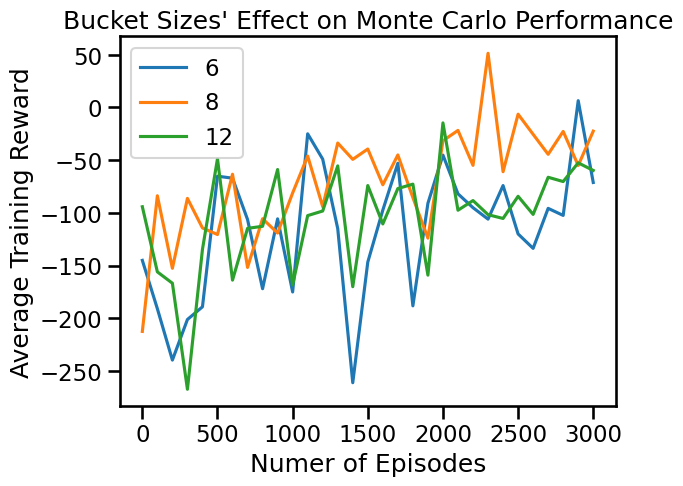

In [90]:
## Plotting
x = np.linspace(0, total_train_episodes, len(performance_buckets[0][0]))

np.mean(performance_buckets[0])
#plt.errorbar(x,np.mean(performance_buckets[0],axis=0),yerr=np.std(performance_buckets[0],axis=0),label='6')
#plt.errorbar(x,np.mean(performance_buckets[1],axis=0),yerr=np.std(performance_buckets[1],axis=0),label='8')
#plt.errorbar(x,np.mean(performance_buckets[2],axis=0),yerr=np.std(performance_buckets[2],axis=0),label='12')
plt.plot(x,np.mean(performance_buckets[0],axis=0),label='6')
plt.plot(x,np.mean(performance_buckets[1],axis=0),label='8')
plt.plot(x,np.mean(performance_buckets[2],axis=0),label='12')

#plt.errorbar(x, y, yerr=yerr, capsize=3, fmt="r--o", ecolor = "black")


plt.ylabel("Average Training Reward")
plt.xlabel("Numer of Episodes")
plt.title("Bucket Sizes' Effect on Monte Carlo Performance")

# Add a legend
plt.legend()

# Show the plot
plt.show()


---

# Experiment 2: Effect of Wind and Turbulence on Variance

In [91]:
## Get one decently trained agent
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)
qTable,rewards = Monte_Carlo(8000,verbal_interval=500)

Episode 0, epsilon 1.0000, reward -140.41
Episode 500, epsilon 0.7773, reward -331.81
Episode 1000, epsilon 0.4767, reward  13.77
Episode 1500, epsilon 0.3007, reward -79.90
Episode 2000, epsilon 0.1759, reward -11.73
Episode 2500, epsilon 0.0790, reward  18.11
Episode 3000, epsilon 0.0100, reward -22.90
Episode 3500, epsilon 0.0100, reward -15.59
Episode 4000, epsilon 0.0100, reward -53.04
Episode 4500, epsilon 0.0100, reward -74.31
Episode 5000, epsilon 0.0100, reward -57.53
Episode 5500, epsilon 0.0100, reward -61.70
Episode 6000, epsilon 0.0100, reward 209.84
Episode 6500, epsilon 0.0100, reward -41.68
Episode 7000, epsilon 0.0100, reward -37.16
Episode 7500, epsilon 0.0100, reward -34.97


In [75]:
env = create_env()

In [96]:
from logging import INFO
def evaluateQTable(qTable, wind=0.0,turbulence=0.0):

  total_test_episodes = 10

  env = gym.make("LunarLander-v2", continuous=False, enable_wind=True,wind_power=wind,turbulence_power=turbulence)
  max_env_steps = env._max_episode_steps
  number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)

  # Stores all the episode rewards
  test_rewards = []

  for episode in range(total_test_episodes):

    # Initialization variables
    episode_rewards = 0
    done =  False

    # Reset the environment getting the initial state
    state,info = env.reset()
    bucket_state = bucketize(state)

    prev_action = 0
    action_counter = 0

    for step in range(max_env_steps):

      bucket_state = bucketize(state)
      action = choose_action(qTable, bucket_state, 0)

      new_state, reward, done,trunc,info = env.step(action)
      bucket_new_state = bucketize(new_state)

      state =  new_state

      ##DEPRECATED: used for the Action Change metric
      #if action != prev_action:
      #  action_counter += 1

      episode_rewards += reward

      prev_action = action

      if done:
        break
    test_rewards.append(episode_rewards)
  return np.mean(test_rewards),np.std(test_rewards)

#myMean,myS = evaluateQTable(qTable)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
MonteCarloMean,MonteCarloSTD = evaluateQTable(qTable)
print(MonteCarloMean,MonteCarloSTD)

-35.282401308242754 31.143208019579106


In [ ]:
def testWinds(qTable):

  windSpeeds = [0.0,5.0,10.0,20.0,30.0]
  turbulences = [0.0,0.5,1.0,2.0,3.0]

  #windSpeeds = [0.0,15.0,30.0]
  #turbulences = [0.0,1.5,3.0]

  windMatrix = np.zeros( ( len(windSpeeds),len(turbulences) )  )
  stdMatrix = np.zeros( ( len(windSpeeds),len(turbulences) )  )

  for idxWind,windSpeed in enumerate(windSpeeds):
    for idxTurbulence,turbulence in enumerate(turbulences):
      windMatrix[idxWind,idxTurbulence], stdMatrix[idxWind,idxTurbulence] = evaluateQTable(qTable,windSpeed,turbulence)

  return windMatrix,stdMatrix

windMatrix,stdMatrix = testWinds(qTable)
print(windMatrix)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.

[[  -9.47417002    2.04399652  -82.47531078  -48.06079498 -110.70358104]
 [ -60.54477126  -11.14263234 -111.4982476   -18.95564541 -198.48757901]
 [  -7.70518183    5.26156663  -97.11756283 -147.74151157 -161.10843206]
 [-103.5096998  -114.90805387  -15.87349124  -93.07881723 -149.57063407]
 [-164.82621508  -91.71925478 -155.78961319 -243.59147108 -234.00768735]]


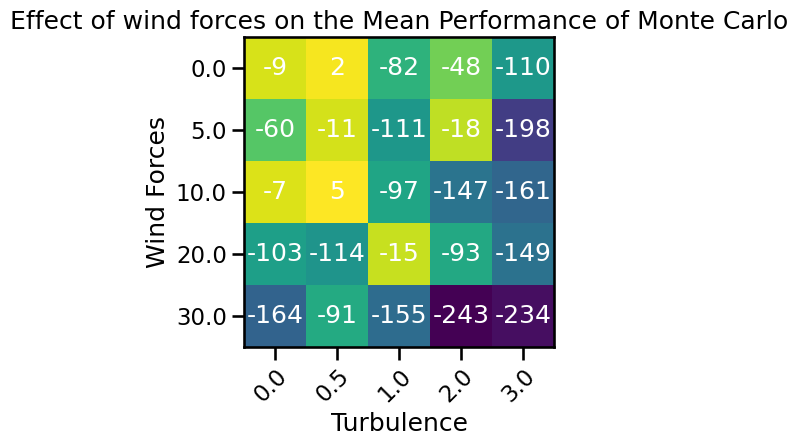

In [ ]:
#windPowers = [0.0,15.0,30.0]
#Turbulences = [0.0,1.5,3.0]


windPowers = [0.0,5.0,10.0,20.0,30.0]
Turbulences = [0.0,0.5,1.0,2.0,3.0]


fig, ax = plt.subplots()
im = ax.imshow(windMatrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(Turbulences)), labels=Turbulences)
ax.set_yticks(np.arange(len(windPowers)), labels=windPowers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(windPowers)):
    for j in range(len(Turbulences)):
        text = ax.text(j, i, int(windMatrix[i, j]),
                       ha="center", va="center", color="w")

plt.ylabel("Wind Forces")
plt.xlabel("Turbulence")

ax.set_title("Effect of wind forces on the Mean Performance of Monte Carlo")
fig.tight_layout()
plt.show()

# Delayed Reward Experiment

In [67]:
# Customized episoder generation function:
##
## We withhold the reward for a set interval, and then give all the accumulated rewards all at once

def Generate_episode_delayed(epsilon, q_table, max_env_steps,interval):
    # Control variables
    total_reward = 0
    done = False

    trayectory = []

    # Reset the environment getting the initial state
    state = env.reset()
    bucket_state = bucketize(state)

    reward_holder = 0

    # Loop for each step of episode:
    for step in range(max_env_steps):

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)

        # Take the action A, observe R, S'
        new_state, reward, done, trunc = env.step(action)
        bucket_new_state = bucketize(new_state)


        if step % interval == 0:
          # Giving the reward all at once if we hit the correct interval
          reward = reward + reward_holder
          reward_holder = 0
        else:
          # Denying the reward if we are outside the interval
          reward_holder += reward
          reward = 0

        trayectory.append([bucket_state, action, reward])

        bucket_state = bucket_new_state

        total_reward += reward

        if done:
            break

    return trayectory, total_reward

In [72]:
def delayedRewardsTestInterval(interval=10):
  qTable,rewards = Monte_Carlo(3000,delayed=True,interval=interval)
  delayedMean, delayedSTD = evaluateQTable(qTable)

  return delayedMean,delayedSTD

In [78]:
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)
total_train_episodes = 3000
def delayedRewardsTestTotal():
  intervals = [1,50,100]

  trials = 8

  interval_performances = [[],[],[]]

  for idx,interval in enumerate(intervals):
    for trial in range(trials):
      delayedMean,delayedSTD = delayedRewardsTestInterval(interval=interval)
      interval_performances[idx].append(delayedMean)

  return interval_performances

interval_performances = delayedRewardsTestTotal()

Episode 0, epsilon 1.0000, reward -96.43
Episode 100, epsilon 1.0000, reward -242.49
Episode 200, epsilon 1.0000, reward -209.65
Episode 300, epsilon 0.9986, reward -133.97
Episode 400, epsilon 0.8740, reward -162.21
Episode 500, epsilon 0.7773, reward -81.53
Episode 600, epsilon 0.6982, reward -61.39
Episode 700, epsilon 0.6314, reward -48.76
Episode 800, epsilon 0.5735, reward -118.88
Episode 900, epsilon 0.5224, reward -49.33
Episode 1000, epsilon 0.4767, reward -36.50
Episode 1100, epsilon 0.4353, reward -60.67
Episode 1200, epsilon 0.3976, reward -70.76
Episode 1300, epsilon 0.3628, reward   0.73
Episode 1400, epsilon 0.3307, reward -41.74
Episode 1500, epsilon 0.3007, reward -81.24
Episode 1600, epsilon 0.2727, reward -17.25
Episode 1700, epsilon 0.2464, reward -94.57
Episode 1800, epsilon 0.2216, reward -74.54
Episode 1900, epsilon 0.1981, reward  29.28
Episode 2000, epsilon 0.1759, reward -33.75
Episode 2100, epsilon 0.1547, reward -70.46
Episode 2200, epsilon 0.1345, reward -1

Text(0.5, 1.0, 'Delayed Reward on the Monte Carlo Performance')

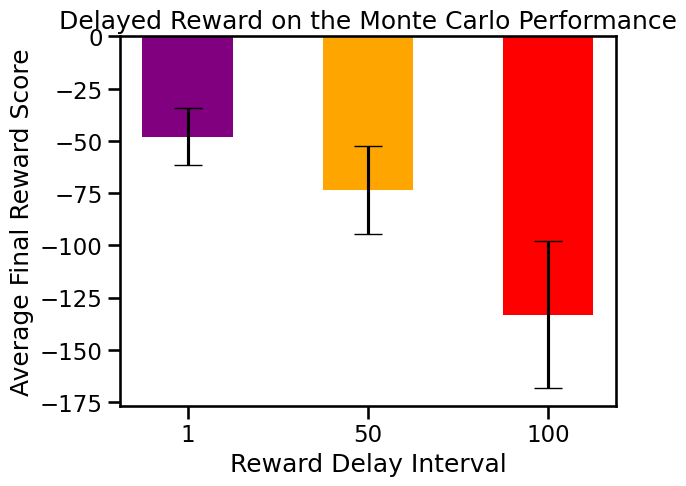

In [79]:
x = ["1", "50","100"]
y = np.mean(interval_performances,axis=1)

error = np.std(interval_performances,axis=1)

# Bar plot
fig, ax = plt.subplots()
bar_colors = ["purple","orange","red"]
ax.bar(x = x, height = y, yerr = error, capsize = 10,width=0.5, color=bar_colors)
plt.xlabel("Reward Delay Interval")
plt.ylabel("Average Final Reward Score")
plt.title("Delayed Reward on the Monte Carlo Performance")

# End of the Experiments in the Report




---



# Visualizing the Monte-Carlo Method at work

-11.95323047184695


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


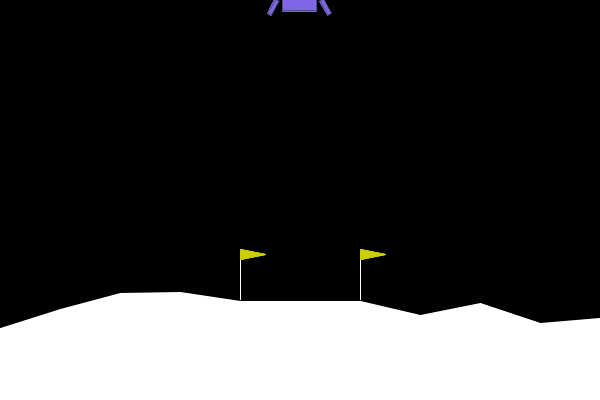

In [92]:
# Naive policies
import gymnasium as gym
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)



state,info = env.reset()
done = False


total_rew = 0
for t in range(300):
    env.render_wrapper.render()

    # action = np.array([-1., 0.])
    # action = np.array([0., 0.])
    #action = env.action_space.sample()   # Random policy
    bucket_state = bucketize(state)
    action = choose_action(qTable, bucket_state, 0)

    state, reward, done, truncated,info = env.step(action)

    total_rew += reward

    if done:
      break

print(total_rew)

env.close()
env.render_wrapper.make_gif("lab7_ex4_explore")



---

